In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt    
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D

# __I/ Import data__

In [2]:
df = pd.read_csv(r'D:\Study Documents\Nam 3\Ki 2\Data Visualization\Project\DataCo PreModeling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178393 entries, 0 to 178392
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           178393 non-null  object 
 1   Days for shipping (real)       178393 non-null  int64  
 2   Days for shipment (scheduled)  178393 non-null  int64  
 3   Delivery Status                178393 non-null  object 
 4   Late Delivery                  178393 non-null  object 
 5   Category Name                  178393 non-null  object 
 6   Store City                     178393 non-null  object 
 7   Store Country                  178393 non-null  object 
 8   Category Id                    178393 non-null  int64  
 9   Customer Id                    178393 non-null  int64  
 10  Customer Name                  178393 non-null  object 
 11  Customer Segment               178393 non-null  object 
 12  Customer Zipcode              

# __II/ Data Checking & Transforming__

In [3]:
# Convert type of column
df['Order Datetime'] = pd.to_datetime(df['Order Datetime'])
df['Shipping Datetime'] = pd.to_datetime(df['Shipping Datetime'])

In [4]:
df[['Order Datetime', 'Shipping Datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178393 entries, 0 to 178392
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Order Datetime     178393 non-null  datetime64[ns]
 1   Shipping Datetime  178393 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.7 MB


In [5]:
# Check null data
df[['Order Datetime', 'Order Id', 'Customer Id', 'Item Total', 'Item Quantity']].isnull().sum()

Order Datetime    0
Order Id          0
Customer Id       0
Item Total        0
Item Quantity     0
dtype: int64

In [6]:
df[(df["Item Subtotal"] <= 0) & (df['Item Quantity'] <= 0)]

,Type,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late Delivery,Category Name,Store City,Store Country,Category Id,Customer Id,...,Profit per Item,Order Region,Order State,Order Status,Product Id,Product Category Id,Product Name,Product Price,Shipping Datetime,Shipping Mode


# __III/ Calculate RFM value__


## __1. Create RFM columns__

In [7]:
# Recency
import datetime as dt 

# Xác định ngày 
reference_date = df['Order Datetime'].max() + pd.Timedelta(days=1)

# Tính RFM 
rfm = df.groupby('Customer Id').agg({
    'Order Datetime' : lambda x : (reference_date - x.max()).days, 
    'Order Id' : 'nunique', 
    'Item Total' : 'sum', 
    'Product Id' : 'nunique'
}).reset_index()

rfm.columns = ['Customer Id', 'Recency', 'Frequency', 'Monetary', 'Diversity']

In [8]:
rfm

,Customer Id,Recency,Frequency,Monetary,Diversity
0,1,762,1,472.450012,1
1,2,106,4,1618.660042,7
2,3,199,5,3189.200037,9
3,4,350,4,1480.709993,6
4,5,427,3,1101.919998,5
...,...,...,...,...,...
18521,18630,1,1,164.380005,1
18522,18631,1,1,123.290001,1
18523,18632,1,1,131.500000,1
18524,18633,1,1,134.789993,1


## __2. Statistic Descriptive__

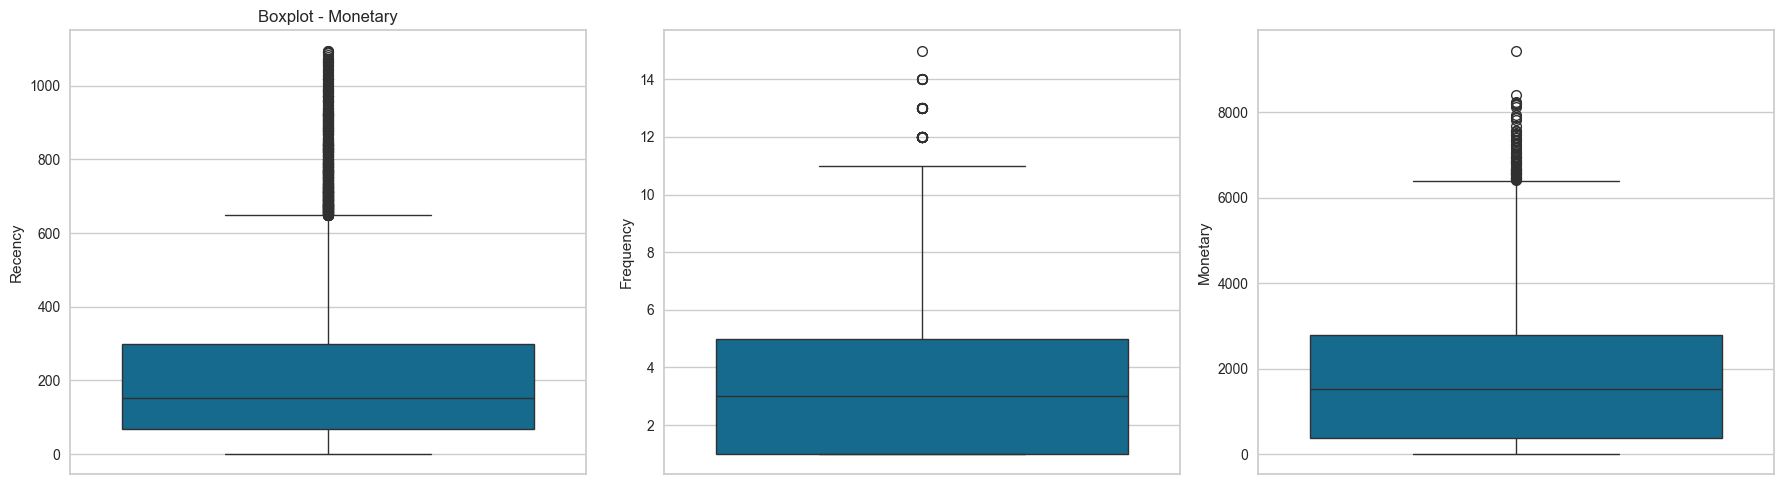

In [9]:
fig, axes = plt.subplots(1,3, figsize = (18, 5))

# Recency 
sns.boxplot(ax = axes[0], y = rfm['Recency'])
axes[0].set_title('Boxplot - Recency')

# Frequency 
sns.boxplot(ax = axes[1], y = rfm['Frequency'])
axes[0].set_title('Boxplot - Frequency')

# Monetary 
sns.boxplot(ax = axes[2], y = rfm['Monetary'])
axes[0].set_title('Boxplot - Monetary')

plt.tight_layout()
plt.show()


In [10]:
rfm.describe()

,Customer Id,Recency,Frequency,Monetary,Diversity
count,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000
mean,9334.249325,213.625445,3.434416,1768.105460,5.347620
std,5380.787596,197.318925,2.444635,1503.959543,3.719006
min,1.000000,1.000000,1.000000,8.470000,1.000000
25%,4675.250000,68.000000,1.000000,369.179993,1.000000
50%,9338.500000,152.000000,3.000000,1526.705023,6.000000
75%,13999.750000,300.000000,5.000000,2779.547535,8.000000
max,18634.000000,1095.000000,15.000000,9436.610088,17.000000


## __3. Handling Outliers__

In [11]:
def remove_outliers_IQR(df, column): 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower = lower_bound, upper = upper_bound)
    return df

for col in ['Recency', 'Frequency', 'Monetary']:
    rfm = remove_outliers_IQR(rfm, col)

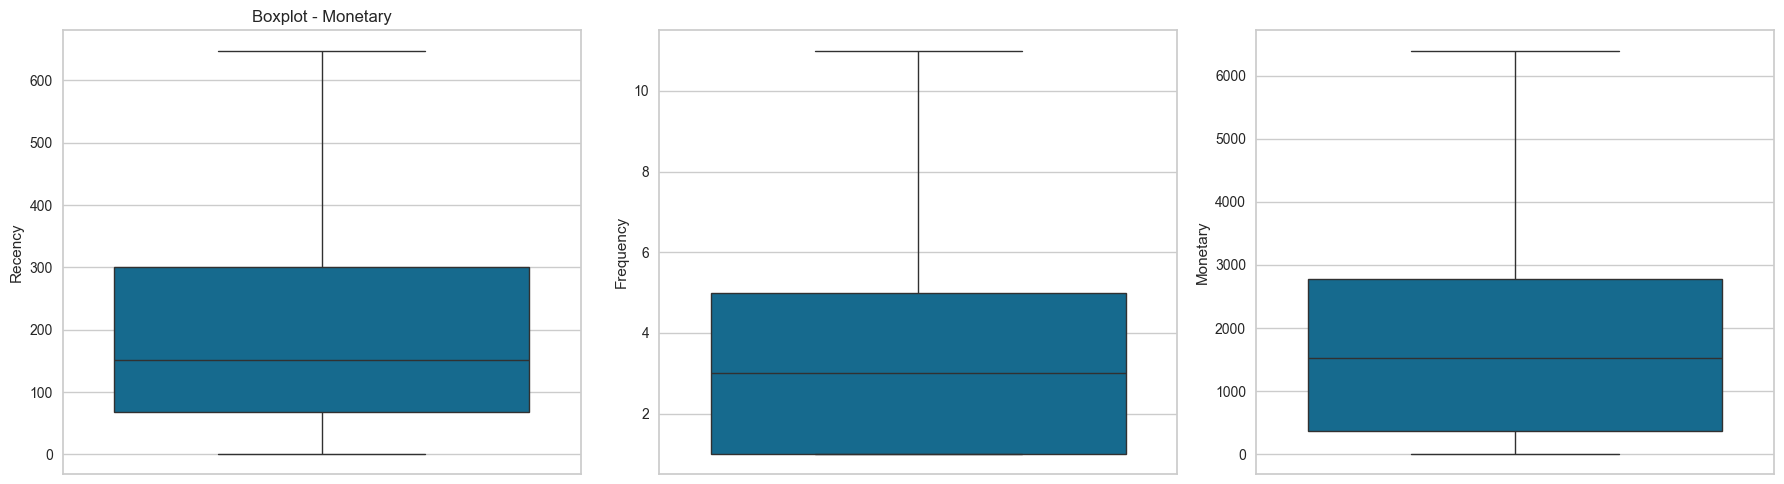

In [12]:
fig, axes = plt.subplots(1,3, figsize = (18, 5))

# Recency 
sns.boxplot(ax = axes[0], y = rfm['Recency'])
axes[0].set_title('Boxplot - Recency')

# Frequency 
sns.boxplot(ax = axes[1], y = rfm['Frequency'])
axes[0].set_title('Boxplot - Frequency')

# Monetary 
sns.boxplot(ax = axes[2], y = rfm['Monetary'])
axes[0].set_title('Boxplot - Monetary')

plt.tight_layout()
plt.show()


# __IV. RFM clustering__

## __1. Standardization__

In [13]:
scaler = StandardScaler() 
rfm_z = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Create RFM Zscore columns
rfm[['Recency_z', 'Frequency_z', 'Monetary_z']] = rfm_z



In [14]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer Id  18526 non-null  int64  
 1   Recency      18526 non-null  int64  
 2   Frequency    18526 non-null  int64  
 3   Monetary     18526 non-null  float64
 4   Diversity    18526 non-null  int64  
 5   Recency_z    18526 non-null  float64
 6   Frequency_z  18526 non-null  float64
 7   Monetary_z   18526 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.1 MB


### __2.  Find optimal K by ELBOW METHOD__

Nb of clusters: 2, WCSS: 27931.778832567827
Nb of clusters: 3, WCSS: 15331.69599321999
Nb of clusters: 4, WCSS: 10400.035879592095
Nb of clusters: 5, WCSS: 8797.404158910189
Nb of clusters: 6, WCSS: 7030.673251188884
Nb of clusters: 7, WCSS: 6211.01372600502
Nb of clusters: 8, WCSS: 5697.814118411637
Nb of clusters: 9, WCSS: 5134.791051934297
Nb of clusters: 10, WCSS: 4832.603923995429


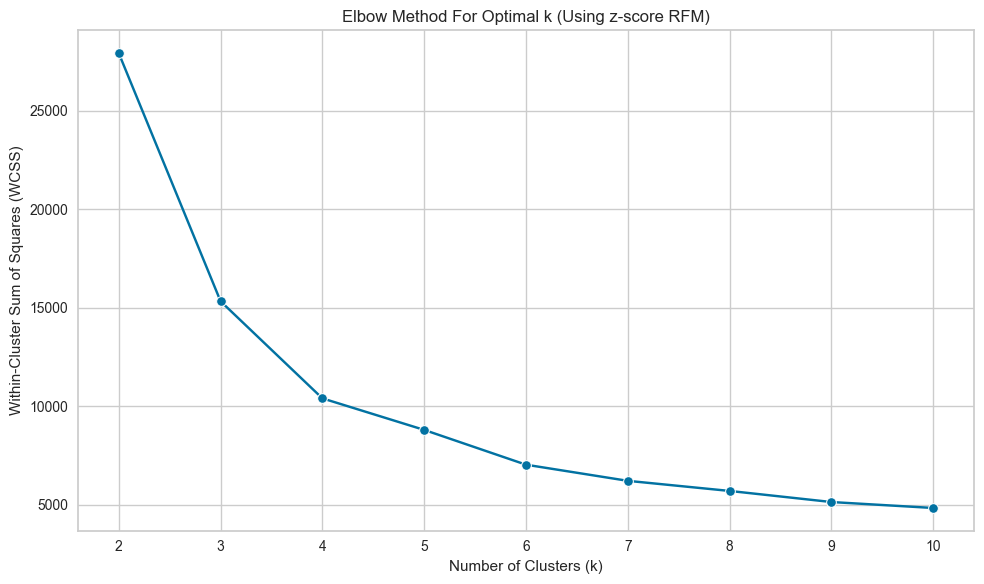

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

wcss = []
range_cluster = range(2,11)

for k in range_cluster:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_z)
    wcss.append(kmeans.inertia_) 

    print(f"Nb of clusters: {k}, WCSS: {wcss[-1]}")

# Elbow plot 
plt.figure(figsize=(10,6))
sns.lineplot(x=list(range_cluster), y=wcss, marker='o')
plt.title('Elbow Method For Optimal k (Using z-score RFM)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range_cluster)
plt.grid(True)
plt.tight_layout()
plt.show()


=> Choose K = 4

### __3.  Cluster Modeling with K = 4__

In [16]:
kmeans = KMeans(n_clusters=4,random_state=42)

kmeans.fit(rfm[['Recency_z','Frequency_z','Monetary_z']])
cluster_label = kmeans.predict(rfm[['Recency_z','Frequency_z','Monetary_z']])

# Labeling for customer
rfm['Cluster'] = cluster_label

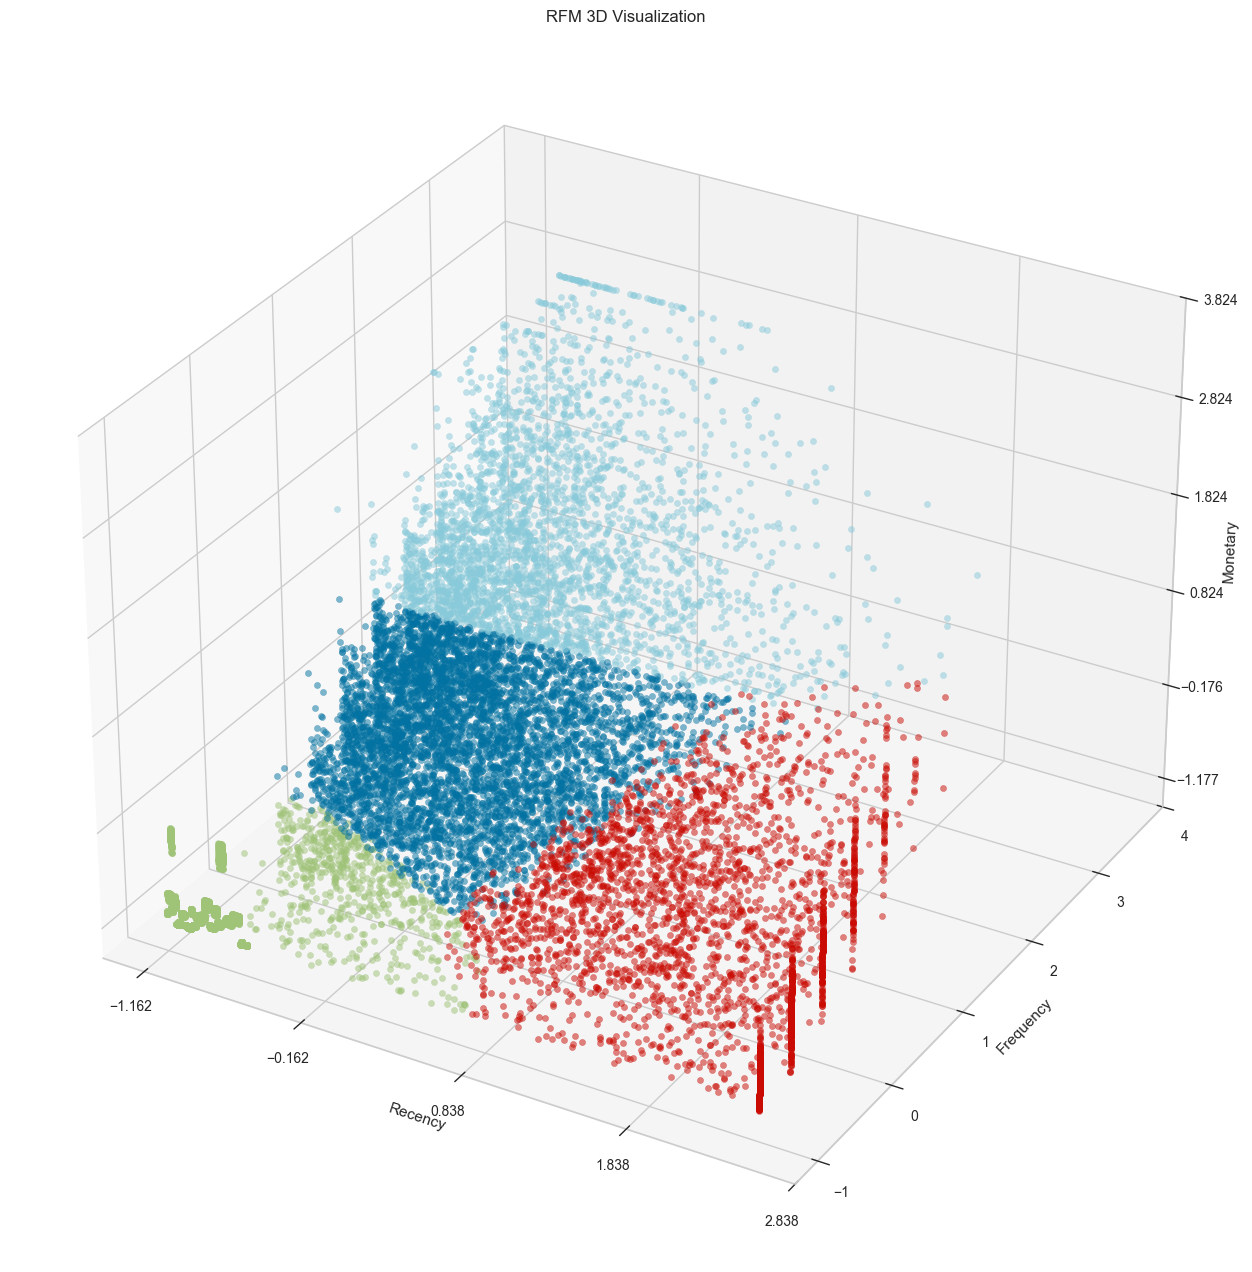

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

x, y, z = rfm['Recency_z'], rfm['Frequency_z'], rfm['Monetary_z']

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for i in range(len(rfm)):
    ax.scatter(x.iloc[i], y.iloc[i], z.iloc[i], c=colors[rfm['Cluster'].iloc[i]], alpha=0.5, marker='o')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM 3D Visualization')

ax.set_xticks(np.arange(min(x), max(x) + 1, x.std()))
ax.set_yticks(np.arange(min(y), max(y) + 1, y.std()))
ax.set_zticks(np.arange(min(z), max(z) + 1, z.std()))

plt.show()  

# __V. EDA clusters__

In [18]:
Cluster = rfm.groupby('Cluster').agg({'Recency_z':'mean','Frequency_z':'mean','Monetary_z':'mean'})
print(Cluster)

         Recency_z  Frequency_z  Monetary_z
Cluster                                    
0         0.061712     0.405142    0.343592
1        -0.843907    -0.963944   -0.940632
2         1.809059    -0.238421   -0.203379
3         0.011408     1.614587    1.642494


In [19]:
Cluster = rfm.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean','Monetary':'mean'})
print(Cluster)

            Recency  Frequency     Monetary
Cluster                                    
0        217.752383   4.415284  2277.894716
1         57.397534   1.087346   360.630782
2        527.149073   2.850927  1461.301470
3        208.845281   7.355174  4217.073409


In [20]:
# LABELLING FOR CLUSTERS
def ClassifyName(x):
    if x == 0:
        return 'Potential Customer'
    elif x == 1:
        return 'New Customer'
    elif x == 2:
        return 'Churn Customer'
    else:
        return 'Loyal Customer'
    
rfm['Customer Classify'] = rfm['Cluster'].apply(lambda x: ClassifyName(x))
rfm = rfm.drop(columns='index')


KeyError: "['index'] not found in axis"

In [ ]:
rfm.head()

,Customer Id,Recency,Frequency,Monetary,Diversity,Recency_z,Frequency_z,Monetary_z,Cluster,Customer Classify
0,1,648,1,472.450012,1,2.491576,-0.999877,-0.865733,2,Churn Customer
1,2,106,4,1618.660042,7,-0.569420,0.234297,-0.097977,0,Potential Customer
2,3,199,5,3189.200037,9,-0.044194,0.645689,0.954003,0,Potential Customer
3,4,350,4,1480.709993,6,0.808593,0.234297,-0.190379,0,Potential Customer
4,5,427,3,1101.919998,5,1.243458,-0.177094,-0.444101,2,Churn Customer


In [ ]:
rfm_diversity_stats = rfm.groupby('Customer Classify')['Diversity'].agg(['mean', 'std'])
print(rfm_diversity_stats)

                         mean       std
Customer Classify                      
Churn Customer       5.570995  2.247529
Loyal Customer      10.026273  1.668395
New Customer         1.276130  0.990900
Potential Customer   7.579951  1.741872


# __VI. Export data__

In [ ]:
# rfm.to_csv('Customer_Cluster.csv')